## **<span style="color:red"> - CNN Implementation on Cat vs Dog with PyTorch  </span>**

<br>

### **<span style="color:Red">  - Imports and Libraries</span>**

In [ ]:
! pip install torchinfo 

import os
import torch
import shutil
import random
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


choose the computation device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
MODEL_NAME = "resnet18"      # options: "lenet5", "alexnet", "vgg16", "resnet18", "inception"

<br>

### **<span style="color:red"> 1. Data Pipeline  </span>**

<br>

#### **<span style="color:black">  i) Connect to Google Drive</span>**

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
DATA_ROOT = "/content/drive/MyDrive/Datasets/cat_vs_dog"

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

<br>

#### **<span style="color:black">  ii) Transform Pipeline for CIFAR-10 Dataset</span>**

We will specify how each raw image will be preprocessed before entering the model.

In [8]:
## Lenet-5
if MODEL_NAME == "lenet5":
  train_transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
  ])

  test_transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
  ])

else:
  ## Other Models on ImageNet
  train_transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
  ])

  test_transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
  ])


<br>

#### **<span style="color:black">  iii.  Scanning training and test sets</span>**

In [9]:
if MODEL_NAME == "lenet5":
    train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
    test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=test_transform)
else:
    train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
    test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=test_transform)


In [10]:
if MODEL_NAME == "lenet5":
  print("Number of training samples:", len(train_dataset))
  print("Number of test samples:", len(test_dataset))

else:
  print("Number of training samples:", len(train_dataset))
  print("Number of test samples:", len(test_dataset))

Number of training samples: 800
Number of test samples: 200


<br>

#### **<span style="color:black">  iv. DataLoaders: Create mini-batches, , to load train & test sets</span>**

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = 2

if MODEL_NAME == "lenet5":
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
  test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

else:
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
  test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [12]:
if MODEL_NAME == "lenet5":
  print(f"Number of training batches: {len(train_loader)}")
  print(f"Number of test batches: {len(test_loader)}")

else:
  print(f"Number of training batches: {len(train_loader)}")
  print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 25
Number of test batches: 7


<br>

#### **<span style="color:black">  iv. Check Everything is Correct (Optional Step)</span>**

In [13]:
# Get one batch of data
images, labels = next(iter(train_loader))

print("Images shape:", images.shape)            # Expected: [32, 3, 32, 32]    For Lenet-5
print("Labels shape:", labels.shape)            # Expected: [32]

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [14]:
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['Cat', 'Dog']


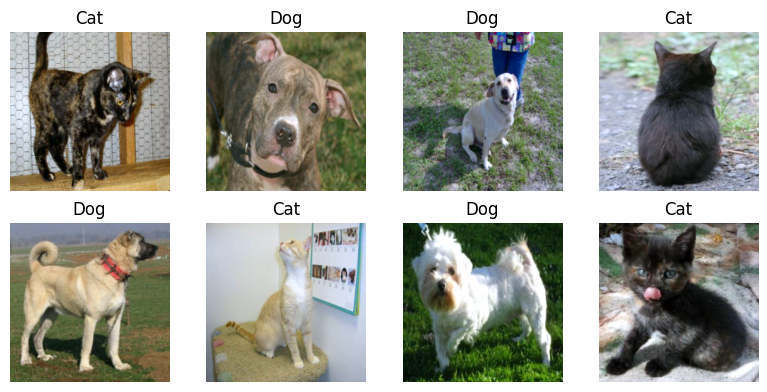

In [15]:
# Helper function to un-normalize and show images
def imshow(img):
    # img: tensor with shape (3, H, W)
    img = img.clone()                                               # avoid modifying original
    # Un-normalize: x * std + mean
    mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3, 1, 1)
    std = torch.tensor((0.2470, 0.2435, 0.2616)).view(3, 1, 1)
    img = img * std + mean
    img = img.clamp(0, 1)                                           # ensure values are in [0,1]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

# Show a few images from the batch
plt.figure(figsize=(8, 4))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

<br>

### **<span style="color:red">  2. CNN Model Architecture</span>**

In [16]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),     # (B, 3, 32, 32) → (B, 6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, 2),                 # → (B, 6, 14, 14)

            nn.Conv2d(6, 16, kernel_size=5),    # → (B, 16, 10, 10)
            nn.Tanh(),
            nn.AvgPool2d(2, 2)                  # → (B, 16, 5, 5)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.classifier(x)
        return x


In [17]:
from torchvision import models

def build_model(name, num_classes=2, pretrained=True):
    name = name.lower()

    if name == "lenet5":
        m = LeNet5(num_classes=num_classes)

    elif name == "alexnet":
        m = models.alexnet(
            weights=models.AlexNet_Weights.DEFAULT if pretrained else None
        )
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes)

    elif name == "vgg16":
        m = models.vgg16(
            weights=models.VGG16_Weights.DEFAULT if pretrained else None
        )
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes)

    elif name == "resnet18":
        m = models.resnet18(
            weights=models.ResNet18_Weights.DEFAULT if pretrained else None
        )
        m.fc = nn.Linear(m.fc.in_features, num_classes)

    elif name == "inception":
        m = models.inception_v3(
            weights=models.Inception_V3_Weights.DEFAULT if pretrained else None,
            aux_logits=True
        )
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        m.AuxLogits.fc = nn.Linear(
            m.AuxLogits.fc.in_features, num_classes
        )

    else:
        raise ValueError("Unknown model")

    return m


<br>

### **<span style="color:red"> 3. Training Pipeline </span>**

<br>

#### **<span style="color:black"> i. Instantiating the Model  </span>**

In [18]:
model = build_model(
    name=MODEL_NAME,
    num_classes=2,
    pretrained=(MODEL_NAME != "lenet5")
).to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [19]:
if MODEL_NAME == "lenet5":
    print(summary(model, input_size=(1, 3, 32, 32)))
else:
    print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

<br>

#### **<span style="color:black"> ii.  Loss Function and Optimizer  </span>**

In [20]:
# Loss function: combines LogSoftmax + NLLLoss for classification
criterion = nn.CrossEntropyLoss()

# Optimizer
if MODEL_NAME == "lenet5":
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
else:
    optimizer = optim.Adam(model.parameters(), lr=1e-4)     # Pretrained models need smaller LR

In [21]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """Train the model for one epoch and return average loss and accuracy."""

    model.train()                                       # set model to training mode (dropout, batch-norm updates)

    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for images, labels in dataloader:
        # 1. Move data to selected device (CPU/GPU)
        images = images.to(device)                      # (N, 3, 32, 32)
        labels = labels.to(device)                      # (N,)               (batch_size,)

        # 2. Reset gradients from previous batch
        optimizer.zero_grad()

        # 3. Forward pass: Whatever you wrote in Architecture's forward() is executed here.
        outputs = model(images)                         # (N, 10)   --> images are passed through the entire model architecture

        # 4. Compute loss
        loss = criterion(outputs, labels)               # Compares model predictions with true labels & Computes a scalar loss value

        # 5. Backward pass
        loss.backward()                    # Computes gradients of the loss  --> for every trainable parameter in the architecture

        # 6. Update parameters
        optimizer.step()                                # Optimizer updates weights:   weight = weight - learning_rate × gradient

        # 7. Accumulate loss
        batch_size = images.size(0)                     # average loss per sample
        running_loss += loss.item() * batch_size        # Multiply to get total loss for this batch

        # 8. Count correct predictions
        _, preds = torch.max(outputs, dim=1)            # preds → (N,)      Selects the class with highest score for each sample
        running_correct += (preds == labels).sum().item()          # Counts how many predictions match true labels

        # 9. Keeps track of total samples processed
        total_samples += batch_size

    epoch_loss = running_loss / total_samples            # average training loss over all samples / entire dataset.
    epoch_acc = running_correct / total_samples          # average training accuracy over all samples.

    return epoch_loss, epoch_acc


<br>

#### **<span style="color:black"> iii.  Evaluation on Validation/Test Data   </span>**

In [22]:
def evaluate(model, dataloader, criterion, device):
    """Evaluate the model on validation/test data (no training , no gradient computation)."""

    model.eval()     # Puts the model arch. into evaluation mode: disables dropout, Uses stored running mean & variance for batch-norm

    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    # Disable gradient tracking for speed and memory savings
    with torch.no_grad():

        for images, labels in dataloader:
            # 1. Move data to selected device (CPU/GPU)
            images = images.to(device)
            labels = labels.to(device)

            # 2. Forward pass: Whatever you wrote in Architecture's forward() is executed here.
            outputs = model(images)                          # Input images pass through the entire model architecture  --> (N, C)

            # 3. Compute loss
            loss = criterion(outputs, labels)           # Compares model predictions with true labels & Computes a scalar loss value

            # 4. Accumulate loss
            batch_size = images.size(0)                     # average loss per sample
            running_loss += loss.item() * batch_size        # Multiply to get total loss for this batch

            # 5. Accumulate loss
            _, preds = torch.max(outputs, dim=1)            # Selects class with highest score per sample
            running_correct += (preds == labels).sum().item()   # Counts correct predictions

            # 6. Keeps track of total samples processed
            total_samples += batch_size


    epoch_loss = running_loss / total_samples                   # epoch_loss: average loss on this dataset.
    epoch_acc = running_correct / total_samples                 # epoch_acc: average accuracy on this dataset.

    return epoch_loss, epoch_acc

<br>

#### **<span style="color:black"> iv.  Training Loop Over Epochs & Evaluation on Validation/Test Data    </span>**

We have now combined everything into a loop that trains for multiple epochs and evaluates on the test set after each epoch.

In [23]:
num_epochs = 2

for epoch in range(num_epochs):
    # 1. Train for one epoch
    train_loss, train_acc = train_one_epoch(        # Performs many mini-batch updates.
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )

    # 2. Evaluate on the test set
    test_loss, test_acc = evaluate(                 # Computes performance on previously unseen test data.
        model=model,                                # No gradient computations are done here.
        dataloader=test_loader,
        criterion=criterion,
        device=device
    )

    # 3. Print progress
    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Train Acc: {train_acc:.4f} "
        f"Test Loss: {test_loss:.4f} "
        f"Test Acc: {test_acc:.4f}"
    )


Epoch [1/2] Train Loss: 0.1527 Train Acc: 0.9513 Test Loss: 0.0366 Test Acc: 0.9950
Epoch [2/2] Train Loss: 0.0237 Train Acc: 0.9912 Test Loss: 0.0291 Test Acc: 0.9900


<br>

### **<span style="color:red"> 4.  Saving, Loading & Predicting the Trained Model (Optional)   </span>**

<br>

i. Saving

In [24]:
# Save only the learned parameters (state_dict) i.e model weights
save_path = f"{MODEL_NAME}_cat_vs_dog.pth"
torch.save(model.state_dict(), save_path)
print("Saved:", save_path)

Saved: resnet18_cat_vs_dog.pth


<br>

ii. Loading

In [25]:
loaded_model = build_model(
    name=MODEL_NAME,
    num_classes=2,
    pretrained=False
).to(device)

loaded_model.load_state_dict(
    torch.load(save_path, map_location=device)
)
loaded_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<br>

iii. Prediction

In [28]:
# Quick inference on a single test image
image, label = test_dataset[0]          # image shape: (3, 32, 32)

# Add batch dimension
image = image.unsqueeze(0).to(device)

with torch.no_grad():
    output = loaded_model(image)
    _, predicted = torch.max(output, 1)

print("True label:", classes[label])
print("Predicted label:", classes[predicted.item()])

True label: Cat
Predicted label: Cat


In [39]:
# Quick inference on a single test image
image, label = test_dataset[0]          # image shape: (3, 224, 224)
image_vis = image.clone()               # Keep a copy for visualization (before batch dimension)

image = image.unsqueeze(0).to(device)   # Add batch dimension for model input

with torch.no_grad():
    output = loaded_model(image)                          # raw logits
    probabilities = torch.softmax(output, dim=1)          # Convert logits to probabilities
    confidence, predicted = torch.max(probabilities, 1)   # Get predicted class index and confidence score


# Print results
print("True label:", classes[label])
print(f"Predicted label: {classes[predicted.item()]} ({confidence.item()*100:.2f}%)")

True label: Cat
Predicted label: Cat (99.72%)


<br>

Display Image

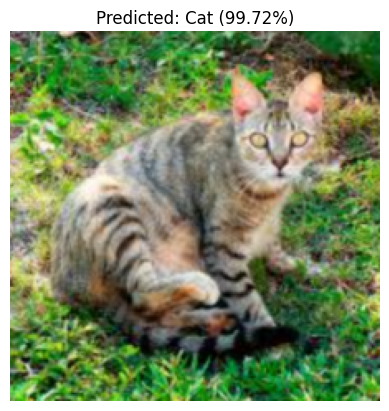

In [40]:
# --------------------------------------------
# Unnormalize image for correct visualization
# (use the SAME mean & std as training)
# --------------------------------------------
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])


img = image_vis * std[:, None, None] + mean[:, None, None]  # unnormalize
img = img.permute(1, 2, 0).cpu().numpy()                    # (H, W, C)


# --------------------------------------------
# Display image with prediction
# --------------------------------------------
plt.imshow(img)
plt.title(f"Predicted: {classes[predicted.item()]} ({confidence.item()*100:.2f}%)")
plt.axis('off')
plt.show()